# Intravoxel incoherent motion (IVIM) imaging

Intra-voxel incoherent motion (IVIM) is a 2-compartment model that separates diffusion signal contributions originating from blood flow and Brownian diffusion *(Le Bihan et al. 1988)*. The model consists of 2 Ball compartments (isotropic Gaussian), each fitting the blood flow and diffusion volume fractions and diffusivities, respectively. Changes in e.g. blood volume fraction has been linked to many pathologies such as the vasculature in tumor tissue *(Le Bihan 2018)*.

\begin{align}
 E_{\textrm{IVIM}}= \underbrace{f_{\textrm{blood}}\overbrace{E_{\textrm{iso}}(\lambda_{\textrm{Blood}})}^{\textrm{Ball}}}_{\textrm{Blood}} + \underbrace{f_{\textrm{Diffusion}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{Diffusion}})}^{\textrm{Ball}}}_{\textrm{Diffusion}}
\end{align}

Because the apparent diffusivity of blood flow is much higher than that of Brownian motion, the optimization bounds for the diffusivities of the two Balls are disjoint; the diffusivies of the diffusion compartment range
between [0.5 - 6]e-3 $mm^2/s$ (results in more precise fit according to *(Gurney-Champion et al. 2016)*), and those of the blood compartment range between [6 - 20]e-3 $mm^2/s$ (following *(Park et al. 2017)*). 

The separability of blood and diffusion signal hinges on the observation that the blood-flow signal is negligible at b-values above 200-400 s/mm^2, but it does have a constribution below that bvalue (and to the b0).
    
Many different optimization strategies have been proposed to fit the IVIM model *(Wong et al. 2018, Gurney-Champion et al. 2018)*, of which in this example we will use Dmipy to implement and fit two:
- Following *(Wong et al. 2018)*, a two-step optimization based on the approach that first fits the 'diffusion' diffusivity by fitting a single Ball compartment to the signal where all b-values below b=400$s/mm^2$ have been truncated. Fixing this initial diffusivity, the 2-compartment model is then fitted to the whole signal.
- Following *(Gurney-Champion et al. 2018)*, they found simply fixing $\lambda_{blood}=7e-9 mm^2/s$ results in the second-best IVIM fitting performance (after fancy Bayesian fitting).

We compare our implemented IVIM algorithms with the one available in Dipy, and evaluate/compare the fitted parameter maps and fitting errors.

## Implementing 2-step IVIM using Dmipy
The 2-step fitting approach used in e.g. *(Wong et al. 2018)* consists of two steps:
- step 1: fit only the "diffusion" part of the data using a single Ball compartment, so the data is truncated to only include measurements above the bvalue_threshold value. This step estimates the "diffusion" S0 (which is lower or equal to the actual SO) and the "diffusion" diffusivity of this compartment.
- step 2: fit the 2-compartment model to the whole signal, but fixing the "diffusion" diffusivity to the value estimated in step 1.

We'll use the same example dataset and acquisition scheme that Dipy uses as well:

### Load IVIM acquisition scheme and data

In [1]:
from dipy.data.fetcher import read_ivim
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy, acquisition_scheme_from_bvalues
img, gtab = read_ivim()
scheme_ivim = gtab_dipy2dmipy(gtab, b0_threshold=1e6, min_b_shell_distance=1e6)
scheme_ivim.print_acquisition_info

data = img.get_data()
data_slice = data[90: 155, 90: 170, 33, :]
test_voxel = data_slice[0, 0]

Dataset is already in place. If you want to fetch it again please first remove the folder /home/lucas/.dipy/ivim 
Acquisition scheme summary

total number of measurements: 21
number of b0 measurements: 1
number of DWI shells: 20

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |N/A                      |N/A        |N/A       |N/A  
1           |1         |10              |N/A                      |N/A        |N/A       |N/A  
2           |1         |20              |N/A                      |N/A        |N/A       |N/A  
3           |1         |30              |N/A                      |N/A        |N/A       |N/A  
4           |1         |40              |N/A                      |N/A        |N/A       |N/A  
5           |1         |60              |N/A                      |N/A        |N/A       |N/A  
6           |1         |80              |N/A                      |N/A        |N/A       |N/A  
7

/home/lucas/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/acquisition_scheme.py:852: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.


### Step 1: Fit only Diffusion model using higher b-value data

In [2]:
bvalue_threshold = 4e8
bvalue_mask = scheme_ivim.bvalues > bvalue_threshold
gaussian_acquisition_scheme = acquisition_scheme_from_bvalues(
    bvalues=scheme_ivim.bvalues[bvalue_mask],
    gradient_directions=scheme_ivim.gradient_directions[
        bvalue_mask])
gaussian_data = test_voxel[bvalue_mask]

/home/lucas/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/acquisition_scheme.py:171: UserWarning: No b0 measurements were detected. Check if the b0_threshold option is high enough, or if there is a mistake in the acquisition design.


In [3]:
from dmipy.signal_models.gaussian_models import G1Ball
from dmipy.core.modeling_framework import MultiCompartmentModel
gaussian_mod = MultiCompartmentModel([G1Ball()])
gaussian_mod.set_parameter_optimization_bounds(
    'G1Ball_1_lambda_iso', [0.5e-9, 6e-9])  # [3]
gaussian_fit = gaussian_mod.fit(
    acquisition_scheme=gaussian_acquisition_scheme,
    data=gaussian_data,
    optimize_S0=True)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.00380110740662 seconds
Fitting of 1 voxels complete in 0.430498123169 seconds.
Average of 0.430498123169 seconds per voxel.


### Step 2: Fit whole signal with 2-compartment IVIM model (D fixed from step 1)

In [4]:
ivim_mod = MultiCompartmentModel([G1Ball(), G1Ball()])
ivim_mod.set_parameter_optimization_bounds(
    'G1Ball_2_lambda_iso', [6e-9, 20e-9])  # [4]
ivim_mod.set_fixed_parameter(
    parameter_name='G1Ball_1_lambda_iso',
    value=gaussian_fit.fitted_parameters['G1Ball_1_lambda_iso'])
ivim_fit_2step = ivim_mod.fit(
    acquisition_scheme=scheme_ivim,
    data=test_voxel,
    optimize_S0=True)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.0126860141754 seconds
Fitting of 1 voxels complete in 0.221951007843 seconds.
Average of 0.221951007843 seconds per voxel.


## Implementing Fixed Dstar IVIM using Dmipy

In [5]:
ivim_mod = MultiCompartmentModel([G1Ball(), G1Ball()])
ivim_mod.set_fixed_parameter(
    'G1Ball_2_lambda_iso', 7e-9)  # following [2]
ivim_mod.set_parameter_optimization_bounds(
    'G1Ball_1_lambda_iso', [.5e-9, 6e-9])  # following [3]
ivim_fit_Dfixed = ivim_mod.fit(
    acquisition_scheme=scheme_ivim,
    data=test_voxel,
    verbose=False)

In [6]:
from dipy.reconst.ivim import IvimModel
ivimmodel = IvimModel(gtab)
ivim_fit_dipy = ivimmodel.fit(test_voxel)

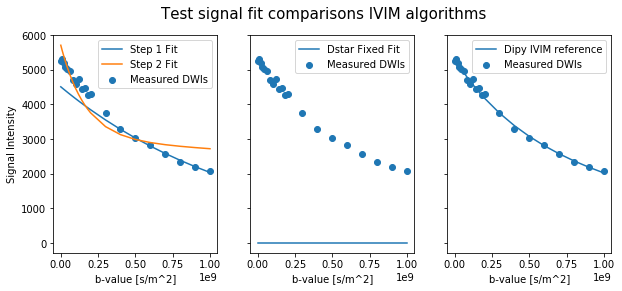

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(ncols=3, figsize=[10, 4], sharey=True)
fig.suptitle('Test signal fit comparisons IVIM algorithms', fontsize=15)
axs[0].set_ylabel('Signal Intensity')
axs[0].set_xlabel('b-value [s/m^2]')
axs[1].set_xlabel('b-value [s/m^2]')
axs[2].set_xlabel('b-value [s/m^2]')

axs[0].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[0].plot(scheme_ivim.bvalues, gaussian_fit.predict(scheme_ivim)[0], label='Step 1 Fit')
axs[0].plot(scheme_ivim.bvalues, ivim_fit_2step.predict()[0], label='Step 2 Fit')
axs[1].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[1].plot(scheme_ivim.bvalues, ivim_fit_Dfixed.predict()[0], label='Dstar Fixed Fit')
axs[2].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[2].plot(scheme_ivim.bvalues, ivim_fit_dipy.predict(gtab), label='Dipy IVIM reference')
for ax in axs:
    ax.legend()

## Parameter map comparison IVIM 2-step, Dstar_fixed, and Dipy reference

In practice we can just load the IVIM implementations above directly as follows:

In [8]:
from dmipy.custom_optimizers.intra_voxel_incoherent_motion import ivim_2step, ivim_Dstar_fixed
ivim_fit_dmipy_2step = ivim_2step(scheme_ivim, data_slice)
ivim_fit_dmipy_fixed = ivim_Dstar_fixed(scheme_ivim, data_slice)
ivim_fit_dipy = ivimmodel.fit(data_slice)

Starting step 1 of IVIM 2-step algorithm.
Starting step 2 of IVIM 2-step algorithm.
Cannot estimate signal grid with voxel-dependent x0_vector.
IVIM 2-step optimization of 5200 voxels complete in 106.958 seconds
Starting IVIM Dstar-fixed algorithm.
IVIM Dstar-fixed optimization of 5200 voxels complete in 57.999 seconds


/home/lucas/anaconda2/lib/python2.7/site-packages/dipy-0.14.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:404: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/lucas/anaconda2/lib/python2.7/site-packages/dipy-0.14.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:498: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/lucas/anaconda2/lib/python2.7/site-packages/dipy-0.14.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:293: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


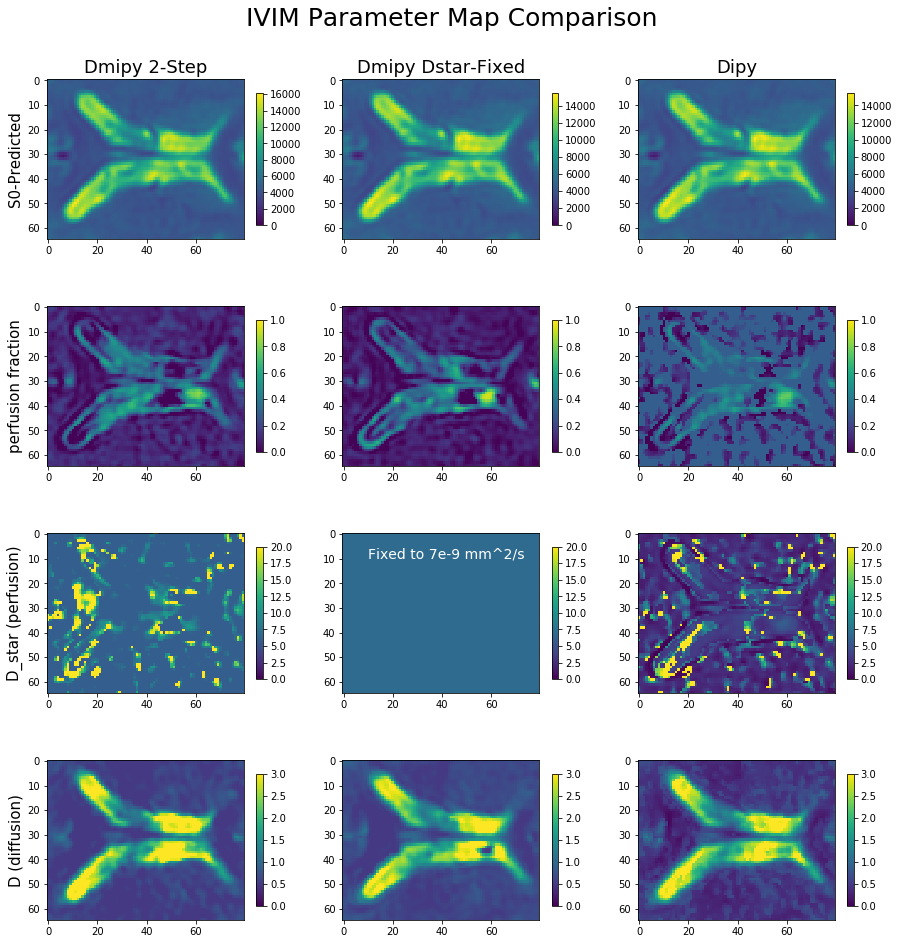

In [9]:
import numpy as np
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=[15, 16])
fig.suptitle('IVIM Parameter Map Comparison', fontsize=25, y=0.93)
axs = axs.ravel()
axs[0].set_title('Dmipy 2-Step', fontsize=18)
axs[1].set_title('Dmipy Dstar-Fixed', fontsize=18)
axs[2].set_title('Dipy', fontsize=18)
axs[0].set_ylabel('S0-Predicted', fontsize=15)
axs[3].set_ylabel('perfusion fraction', fontsize=15)
axs[6].set_ylabel('D_star (perfusion)', fontsize=15)
axs[9].set_ylabel('D (diffusion)', fontsize=15)

args = {'vmin': 0., 'interpolation': 'nearest'}
im0 = axs[0].imshow(ivim_fit_dmipy_2step.S0, **args)
im1 = axs[1].imshow(ivim_fit_dmipy_fixed.S0, **args)
im2 = axs[2].imshow(ivim_fit_dipy.S0_predicted, **args)
im3 = axs[3].imshow(ivim_fit_dmipy_2step.fitted_parameters['partial_volume_1'], vmax=1., **args)
im4 = axs[4].imshow(ivim_fit_dmipy_fixed.fitted_parameters['partial_volume_1'], vmax=1., **args)
im5 = axs[5].imshow(ivim_fit_dipy.perfusion_fraction, vmax=1., **args)
im6 = axs[6].imshow(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_2_lambda_iso'] * 1e9, vmax=20, **args)
im7 = axs[7].imshow(np.ones_like(ivim_fit_dmipy_2step.S0) * 
                    ivim_fit_dmipy_fixed.fitted_and_linked_parameters['G1Ball_2_lambda_iso'] * 1e9, vmax=20, **args)
axs[7].text(10, 10, 'Fixed to 7e-9 mm^2/s', fontsize=14, color='white')
im8 = axs[8].imshow(ivim_fit_dipy.D_star * 1e3, vmax=20, **args)
im9 = axs[9].imshow(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmax=3, **args)
im10 = axs[10].imshow(ivim_fit_dmipy_fixed.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmax=3, **args)
im11 = axs[11].imshow(ivim_fit_dipy.D * 1e3, vmax=3, **args)

for im, ax in zip([im0, im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11], axs):
    fig.colorbar(im, ax=ax, shrink=0.7)

/home/lucas/.local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


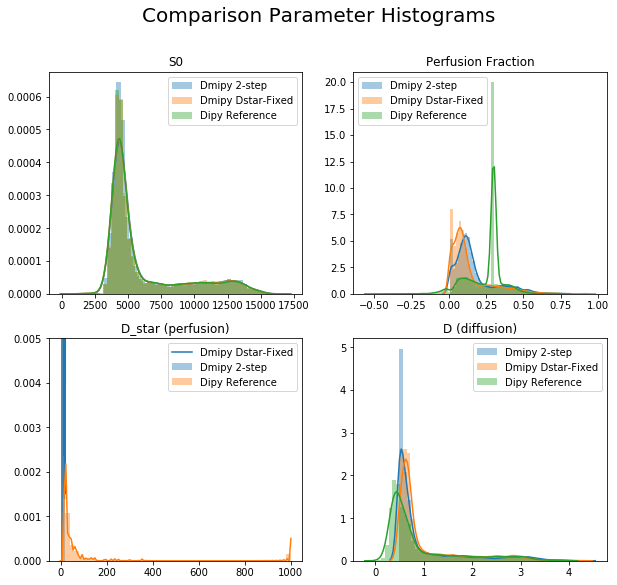

In [10]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=[10, 9])
fig.suptitle('Comparison Parameter Histograms', fontsize=20)
axs = axs.ravel()
sns.distplot(ivim_fit_dmipy_2step.S0.ravel(), ax=axs[0], label='Dmipy 2-step')
sns.distplot(ivim_fit_dmipy_fixed.S0.ravel(), ax=axs[0], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.S0_predicted.ravel(), ax=axs[0], label='Dipy Reference')
axs[0].set_title('S0')

sns.distplot(ivim_fit_dmipy_2step.fitted_parameters['partial_volume_1'].ravel(), ax=axs[1], label='Dmipy 2-step')
sns.distplot(ivim_fit_dmipy_fixed.fitted_parameters['partial_volume_1'].ravel(), ax=axs[1], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.perfusion_fraction.ravel(), ax=axs[1], label='Dipy Reference')
axs[1].set_title('Perfusion Fraction')

sns.distplot(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_2_lambda_iso'].ravel() * 1e9, ax=axs[2], label='Dmipy 2-step')
axs[2].axvline(x=7, label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.D_star.ravel() * 1e3, ax=axs[2], label='Dipy Reference')
axs[2].set_ylim(0, 0.005)
axs[2].set_title('D_star (perfusion)')

sns.distplot(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_1_lambda_iso'].ravel() * 1e9, ax=axs[3], label='Dmipy 2-step')
sns.distplot(ivim_fit_dmipy_fixed.fitted_parameters['G1Ball_1_lambda_iso'].ravel() * 1e9, ax=axs[3], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.D.ravel() * 1e3, ax=axs[3], label='Dipy Reference')
axs[3].set_title('D (diffusion)')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

### Fitting error comparison

In [11]:
mse_2step = ivim_fit_dmipy_2step.mean_squared_error(data_slice)
mse_Dstar_fixed = ivim_fit_dmipy_fixed.mean_squared_error(data_slice)
mse_dipy = np.mean(
    (ivim_fit_dipy.predict(gtab) / ivim_fit_dipy.S0_predicted[..., None] - 
     data_slice / ivim_fit_dipy.S0_predicted[..., None]) ** 2, axis=-1)

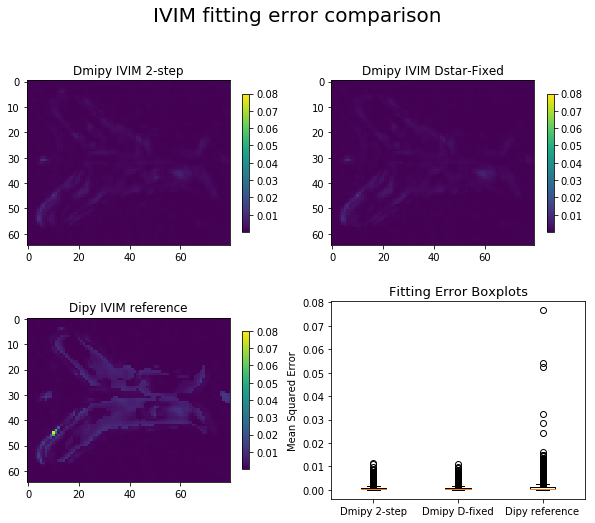

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[10, 8])
fig.suptitle('IVIM fitting error comparison', fontsize=20)
axs = axs.ravel()
im0 = axs[0].imshow(mse_2step, vmax=0.08)
im1 = axs[1].imshow(mse_Dstar_fixed, vmax=0.08)
im2 = axs[2].imshow(mse_dipy, vmax=0.08)

axs[0].set_title('Dmipy IVIM 2-step')
axs[1].set_title('Dmipy IVIM Dstar-Fixed')
axs[2].set_title('Dipy IVIM reference')

for im, ax in zip([im0, im1, im2], axs):
    fig.colorbar(im, ax=ax, shrink=0.7)

axs[3].boxplot(
    x=[mse_2step.ravel(), mse_Dstar_fixed.ravel(), mse_dipy.ravel()],
    labels=['Dmipy 2-step', 'Dmipy D-fixed', 'Dipy reference']);
axs[3].set_ylabel('Mean Squared Error')
axs[3].set_title('Fitting Error Boxplots', fontsize=13);

#### References
- Le Bihan, D., Breton, E., Lallemand, D., Aubin, M. L., Vignaud, J., & Laval-Jeantet, M. (1988). Separation of diffusion and perfusion in intravoxel incoherent motion MR imaging. Radiology, 168(2), 497-505.
- Le Bihan, D. (2017). What can we see with IVIM MRI?. NeuroImage
- Gurney-Champion OJ, Froeling M, Klaassen R, Runge JH, Bel A, Van Laarhoven HWM, et al. Minimizing the Acquisition Time for Intravoxel Incoherent Motion Magnetic Resonance Imaging Acquisitions in the Liver and Pancreas. Invest Radiol. 2016;51: 211–220.
- Park HJ, Sung YS, Lee SS, Lee Y, Cheong H, Kim YJ, et al. Intravoxel incoherent motion diffusion-weighted MRI of the abdomen: The effect of fitting algorithms on the accuracy and reliability of the parameters. J Magn Reson Imaging. 2017;45: 1637–1647.
- Wong, S. M., Backes, W. H., Zhang, C. E., Staals, J., van Oostenbrugge, R. J., Jeukens, C. R. L. P. N., & Jansen, J. F. A. (2018). On the Reproducibility of Inversion Recovery Intravoxel Incoherent Motion Imaging in Cerebrovascular Disease. American Journal of Neuroradiology.
- Gurney-Champion, O. J., Klaassen, R., Froeling, M., Barbieri, S., Stoker, J., Engelbrecht, M. R., ... & Nederveen, A. J. (2018). Comparison of six fit algorithms for the intra-voxel incoherent motion model of diffusion-weighted magnetic resonance imaging data of pancreatic cancer patients. PloS one, 13(4), e0194590.